# GIFT128 - COFTB Side Channel Attacks 

## CS6630 Project: Secure Processor Microarchitecture
Arun Krishna AMS (EE19B001) &Yogasanthoshi (CS19B049)



This jupyter notebook contains the necessary procedure to collect and organize the power traces for the side channel attacks

In [ ]:
# Scope & target platform as CWNANO and SimpleSerial Communication
PLATFORM = 'CWNANO'
SCOPETYPE = 'CWNANO'
SS_VER = 'SS_VER_1_1'

## Building Firmware
Rerun everytime the target code is modified 

In [2]:
#Building Firmware based on the Target, Scope, Serial Communication
#Note: The target firmware location must be appropriately modified
%%bash -s "$PLATFORM"
cd ../hardware/victims/firmware/attack-initial
make PLATFORM=CWNANO CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
make[1]: '.dep' is up to date.
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:9-2019-q4-0ubuntu1) 9.2.1 20191025 (release) [ARM/arm-9-branch revision 277599]
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling:
-en     attack-initial.c ...
-e Done!
.
Compiling:
-en     crypto_coft.c ...
-e Done!
.
Compiling:
-en     gift128.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f0_nano/stm32f0_hal_nano.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f0/stm32f0_hal_lowlevel.c ...
-e Done!
.
Assembling: .././hal/stm32f0/stm32f0_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m0 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -ffunction-sections -DF_CPU=7372800

## Connecting to Hardware

Let's setup the ChipWhisperer

In [3]:
%run "Setup_Generic.ipynb"

(ChipWhisperer NAEUSB WARNING|File naeusb.py:713) Your firmware (0.62) is outdated - latest is 0.64 See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


INFO: Found ChipWhisperer😍


## Uploading Firmware

The following code will upload firmware to the target. Run it after you've built the firmware:

In [4]:
#Note: Target Firmware must be sourced from appropriate location
cw.program_target(scope, prog, "../hardware/victims/firmware/attack-initial/attack-initial-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F04xxx
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6463 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6463 bytes


## Obtaining Power trace

In [5]:
target.read()

#Changing the number of samples collected from default 5000 to 100000 since the time taken for execution is quite high. 
#100000 is the maximum number of samples that can be obtained in a single trace. We observe that 
#the this is not sufficient to observe the entire GIFT-COFTB AEAD Implementation. 100000 samples are
#sufficient to observe the power trace when GIFT-128 is run
scope.adc.samples = 100000

#Sending 16 byte Nonce
nonce = bytearray([0]*16) 
target.simpleserial_write('n', nonce)
target.simpleserial_wait_ack()         #Waiting for Acknowledgment

#Sending 16 byte Key
key = bytearray([0]*16) 
target.simpleserial_write('k', key)
target.simpleserial_wait_ack()         #Waiting for Acknowledgment

#Sending 16 byte Header.
#The number of bytes to be sent in header is fixed, since SimpleSerial V1 can send only fixed number of bytes
#For sending variable length message, V2 must be used
header = bytearray([0]*16)
target.simpleserial_write('h', header)
target.simpleserial_wait_ack()         #Waiting for Acknowledgment     

#Sending 16 byte Plain Text.
#The number of bytes to be sent in plain text is fixed, since SimpleSerial V1 can send only fixed number of bytes
#For sending variable length message, V2 must be used
plaintext = bytearray([0]*16)
target.simpleserial_write('p', plaintext)
target.simpleserial_wait_ack()        #Waiting for Acknowledgment

x = bytearray([0])                    #Temporary variable - random - doesn't matter

#Capture of power trace
scope.arm()                           #Arming the scope for attack
target.simpleserial_write('e',x)      #Start the encryption. The power trace during this encyrption is obtained
ret = scope.capture()
if ret:
    print('Timeout happened during acquisition')

trace = scope.get_last_trace()        #Obtaining the power trace from the scope
target.simpleserial_write('c',x)      #Obtaining the cipher text from the target
ciphertext = target.simpleserial_read('r', 32)

<IPython.core.display.Javascript object>


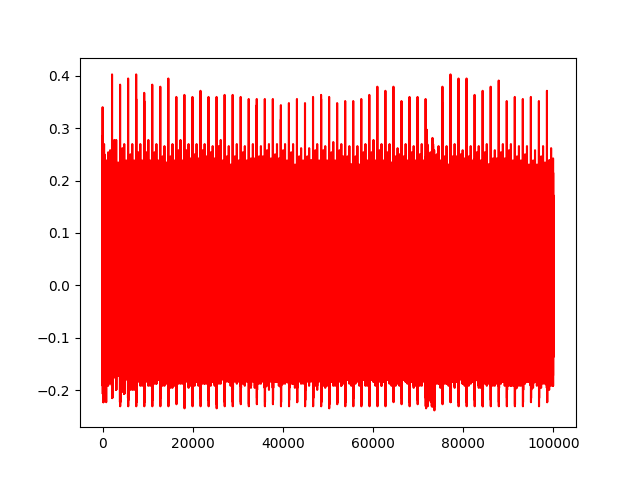

In [7]:
#Plotting the trace to view the results
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
plt.plot(trace, 'r')
plt.show()

## Obtaining Power traces to obtain Key

In [ ]:
import random
import numpy as np

#Total number of traces is set to 1000. Anything more than this number, the Serial Communication becomes extremely
#slow after 1000 or so traces - Posssibly due to fillup of buffers. 
num_traces = 1000

#Generating a random 16 byte key and storing the key
key = bytearray([random.randrange(0,255) for _ in range(16)]) 
key_array = np.array([key])

scope.adc.samples = 100000
x = bytearray([0])

temp_traceround = 0

In [10]:
target.read() #Done to clear the serial buffers

#Generating a random 16 byte nonce & Store the nonce in an array
nonce = bytearray([random.randrange(0,255) for _ in range(16)])
nonce_array = np.array([nonce])

#Generating a random 16 byte header & Store the header in an array
header = bytearray([random.randrange(0,255) for _ in range(16)])
header_array = np.array([header])

#Generating a random 16 byte plaintext & Store the plaintext in an array
plaintext = bytearray([random.randrange(0,255) for _ in range(16)])
plaintext_array = np.array([plaintext])

target.simpleserial_write('n', nonce)           #Sending the Nonce
target.simpleserial_wait_ack()                  #Waiting for Acknowledgement
target.simpleserial_write('k', key)             #Sending the key
target.simpleserial_wait_ack()                  #Waiting for Acknowledgement
target.simpleserial_write('h', header)          #Sending the header
target.simpleserial_wait_ack()                  #Waiting for Acknowledgement
target.simpleserial_write('p', plaintext)       #Sending the plaintext
target.simpleserial_wait_ack()                  #Waiting for Acknowledgement

scope.arm()                                     #Arming the scope for capturing trace
target.simpleserial_write('e',x)                #Start Encryption
ret = scope.capture() 
if ret:
    print('Timeout happened during acquisition')
trace = scope.get_last_trace()                  #Obtain the trace
trace_array = np.array([trace])                 #Store the trace in an array 

target.simpleserial_write('c',x)                #Obtaining the cipher text
ciphertext = target.simpleserial_read('r', 32)
ciphertext_array = np.array([ciphertext])       #Storing the cipher text in an array 




#Doing the above operation for 1000 traces
for i in range(num_traces-1):
    
    target.read()  #Done to clear the serial buffers

    #Generating a random 16 byte nonce & Store the nonce in an array
    nonce = bytearray([random.randrange(0,255) for _ in range(16)])
    nonce_array = np.append(nonce_array,[nonce],axis=0)

    #Generating a random 16 byte header & Store the header in an array
    header = bytearray([random.randrange(0,255) for _ in range(16)])
    header_array = np.append(header_array,[header],axis=0)

    #Generating a random 16 byte plaintext & Store the plaintext in an array
    plaintext = bytearray([random.randrange(0,255) for _ in range(16)])
    plaintext_array = np.append(plaintext_array,[plaintext],axis=0)

    target.simpleserial_write('n', nonce)           #Sending the Nonce
    target.simpleserial_wait_ack()                  #Waiting for Acknowledgement
    target.simpleserial_write('k', key)             #Sending the key
    target.simpleserial_wait_ack()                  #Waiting for Acknowledgement
    target.simpleserial_write('h', header)          #Sending the header
    target.simpleserial_wait_ack()                  #Waiting for Acknowledgement
    target.simpleserial_write('p', plaintext)       #Sending the plaintext
    target.simpleserial_wait_ack()                  #Waiting for Acknowledgement

    scope.arm()                                     #Arming the scope for capturing trace
    target.simpleserial_write('e',x)                #Start Encryption
    ret = scope.capture() 
    if ret:
        print('Timeout happened during acquisition')
    trace = scope.get_last_trace()                       #Obtain the trace
    trace_array = np.append(trace_array,[trace],axis=0)  #Store the trace in an array 
  
    target.simpleserial_write('c',x)                     #Obtaining the cipher text
    ciphertext = target.simpleserial_read('r', 32)
    ciphertext_array = np.append(ciphertext_array,[ciphertext],axis=0)  #Storing the cipher text in an array

    #Printing Progress
    if(i%100 == 0):
        print(i)
    

    
    

0
100
200
300
400
500
600
700
800
900


In [12]:
#Storing the arrays in the files for processing
#Note: The files must be placed in appropriate locations
with open('traces\key.npy', 'wb') as f:
    np.save(f, key_array)
with open('traces\plain_text.npy', 'wb') as f:
    np.save(f, plaintext_array)
with open('traces\nonce_text.npy', 'wb') as f:
    np.save(f, nonce_array)
with open('traces\cipher_text.npy', 'wb') as f:
    np.save(f, ciphertext_array)
with open('traces\header_text.npy', 'wb') as f:
    np.save(f, header_array)
with open('traces\trace.npy', 'wb') as f:
    np.save(f, trace_array)


In [ ]:
#Disconnecting Scope and Target from the notebook
scope.dis()
target.dis()